## Latent Dimention - First Exploration

Con la arquitectura de nuestro CAE determinada en 4.0, buscamos la dimensión mínima del espacio latente que pueda reproducir los datos de entrada con una dada precisión. Para eso vamos a entrenar distintos modelos en los que solo se varía la dimensión del espacio latente y buscar un codo en el score medio de las últimas 10 epochs.

In [1]:
import json
import os
import pickle

from kneed import KneeLocator
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm

from deep_scattering_models.models.convolutional_autoencoder import ConvAutoencoder, save_model, load_cae_model
from deep_scattering_models.data.create_data import load_data
from deep_scattering_models.features.preprocess_data import to_dB, remove_outliers, RScaler_beta
from deep_scattering_models.models.model_wrappers import build_cae_architecture
from deep_scattering_models.models.select_model import load_configuration, k_fold_cv, save_configuration
from deep_scattering_models.visualization.visualize import plot_polarization_signature, plot_history

2023-01-13 17:44:44.918779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 17:44:46.705247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-01-13 17:44:46.705381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-01-13 17:44:46.705389: W tensorflow/compiler/tf2tensorrt/utils/py_uti

Comenzamos cargando los datos y la configuración de nuestro CAE

In [2]:
raw_data_filename = "raw/spm_signatures_no_noise"
raw_data = load_data(raw_data_filename)

In [3]:
data_no_outliers = remove_outliers(raw_data, k=100)
data_dB = to_dB(data_no_outliers)
train_set, test_set = train_test_split(
    data_dB, 
    test_size=.2, 
    random_state=123
    )

Tamaño de los datos de entrenamiento: (4975, 45, 90)


In [ ]:
train_set= np.expand_dims(train_set, axis=-1) 
test_set = np.expand_dims(test_set, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {train_set.shape}')
print(f'Tamaño de los datos de testeo: {test_set.shape}')

In [4]:
cae_configuration = load_configuration("model_architecture_spm.json")

Variamos la dimensión del espacio latente de 16 unidades a 1 unidad. Registramos el MSE y el MAE del conjunto de testeo para cada una de las configuraciones.

In [5]:
# Initialize list for results
models_scores = []
not_tested_configurations = []

config_keys = ('conv_layers_config', 'dense_layers_config')

for lat_dim in tqdm(range(1, 17)):
    configuration = {keys : cae_configuration[keys] for keys in config_keys}
    configuration.update({"latent_dimension" : lat_dim})
    configuration.update({"batch_size" : 16})

    try:
        k_fold_score = k_fold_cv(
            train_set, 
            build_cae_architecture, 
            configuration
            )
    
    except tf.errors.ResourceExhaustedError:
        # If gpu memory is exhausted
        not_tested_configurations.append(configuration)
        
        raise Warning(('La actual configuración agotó los recursos '
        f'de memoria y no fue evaluada: \n {configuration}'))  
    
    else:
        # Update scores
        configuration.update(k_fold_score)
        models_scores.append(configuration)

    finally:
        continue    

100%|██████████| 16/16 [3:09:28<00:00, 710.54s/it]  


In [6]:
df_score = pd.DataFrame.from_records(models_scores)
df_score

,conv_layers_config,dense_layers_config,latent_dimension,batch_size,score,train_score
0,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},1,16,0.004104,0.004646
1,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},2,16,0.001349,0.001393
2,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},3,16,0.000800,0.000937
3,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},4,16,0.000779,0.000880
4,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},5,16,0.001177,0.001112
5,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},6,16,0.001183,0.001130
6,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},7,16,0.000943,0.001091
7,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},8,16,0.000951,0.001034
8,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},9,16,0.001031,0.001131
9,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...",{'layers_units': [256]},10,16,0.000751,0.000683


Guardamos los scores serializados en un pkl

In [7]:
# Get resutls directory path
src_dir = os.path.normpath(os.getcwd() + '/..')
results_dir = os.path.join(src_dir, 'results/spm')

# File name and dir
file_name = 'spm_ld_scores.pkl'
file_dir = os.path.join(results_dir, file_name)

# Save model_scores as pkl
with open(file_dir, 'wb') as f:
   pickle.dump(models_scores, f)

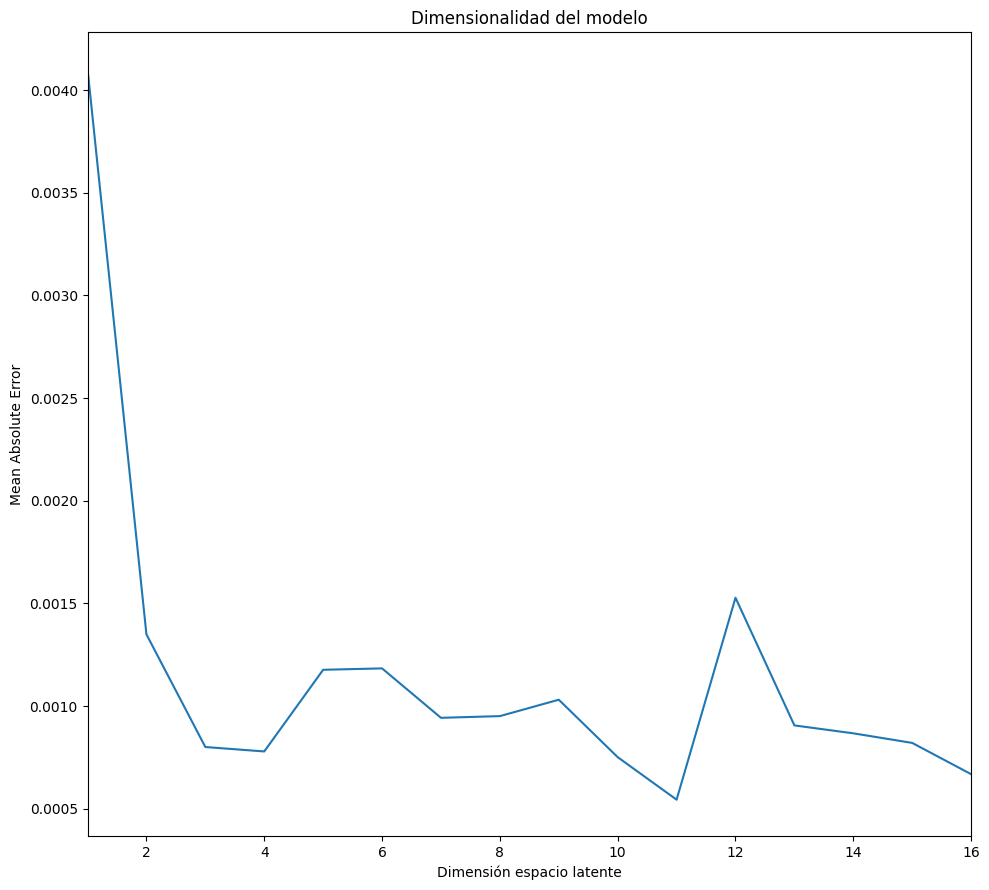

In [8]:
from matplotlib import pyplot as plt
# Visualizo los errores -  Mean Absolute error
fig, ax = plt.subplots(figsize = (10,9))
ax.plot(range(1, 17), df_score['score'])
ax.set_title('Dimensionalidad del modelo')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Dimensión espacio latente')
ax.set_xlim((1, 16))
plt.tight_layout()

Buscamos el codo con un método basado en la derivada segunda de la curva y entrenamos un modelo con el número de unidades del epacio latente resultantes.

In [9]:
# Cargo los scores de cada modelo
with open(file_dir, "rb") as file_:
    scores = pickle.load(file_)

df_scores = pd.DataFrame.from_records(scores)    

kl = KneeLocator(range(1, 17), df_scores["score"], curve="convex", direction="decreasing")
print(f"El como está en dim={kl.elbow}")

El como está en dim=3


In [10]:
cae_configuration = load_configuration("model_architecture_spm.json")
config_keys = ('conv_layers_config', 'dense_layers_config')

configuration = {keys : cae_configuration[keys] for keys in config_keys}
configuration.update({"latent_dimension" : int(kl.elbow)})

print(configuration)

{'conv_layers_config': {'layers_config': [[4, [3, 4], 2], [4, [3, 3], 1]], 'kernel_initializer': 'glorot_uniform'}, 'dense_layers_config': {'layers_units': [256]}, 'latent_dimension': 3}


Con el valor mínimo de unidades en el espacio latente que reconstruyen las firmas, entrenamos nuestro modelo final que sirve para traducir firmas polarimétricas en variables del espacio latente. 

Para el entrenamiento utilizamos todos los datos disponibles.

In [11]:
# Scale each set
scaler = RScaler_beta().fit(data_dB)
scaled_data = scaler.transform(data_dB)

# Add extra dimension for ConvAE input
scaled_data = np.expand_dims(scaled_data, axis=-1)
data_shape = scaled_data.shape
print(f"Tamaño de los datos: {data_shape}")

# Separate in two smaller batchs for sucessive training
half = data_shape[0]//2
first_batch = scaled_data[:half]
second_batch = scaled_data[half:]

print(f"Tamaños de los batchs: {first_batch.shape[0]} y {second_batch.shape[0]}")

Tamaño de los datos: (6219, 45, 90, 1)
Tamaños de los batchs: 3109 y 3110


In [12]:
# Compilamos y entrenamos nuestro modelo final
final_cae = ConvAutoencoder(
    latent_dim=kl.elbow, 
    input_shape=data_shape[1:],
    conv_layers=configuration['conv_layers_config'],
    dense_layers=configuration['dense_layers_config']
    ) 

# Compilamos y ajustamos nuestro modelo con los datos estandarizados
final_cae.compile(
    optimizer='adam', 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=['mean_absolute_error', 'mean_squared_error']
    )

history = final_cae.fit(
    scaled_data, 
    scaled_data,
    epochs=200,
    batch_size=16,
    verbose=0,
    )

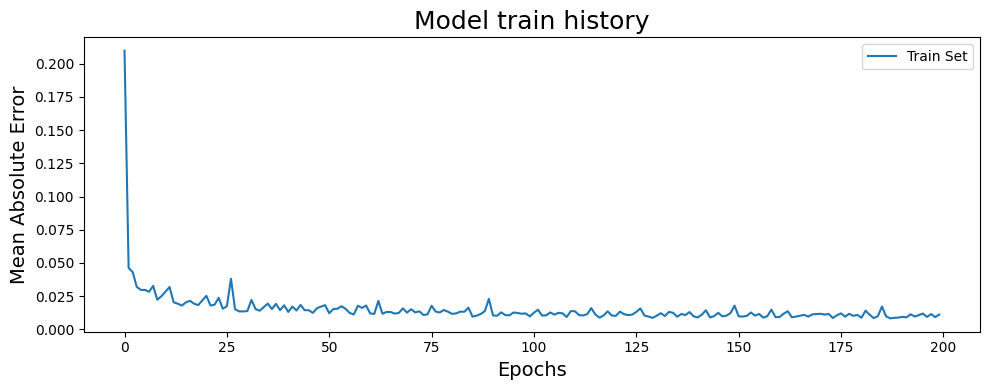

In [13]:
ax = plt.gca()  

# Unpack train and test metrics and scores
metric = "mean_absolute_error"
train_metric = metric

train_score = history.history[train_metric]

# Plot scores in ax
ax.plot(train_score, label='Train Set')


ax.set_xlabel("Epochs", fontsize=14)
ax.set_ylabel(" ".join(metric.split("_")).title(), fontsize=14)
ax.set_title("Model train history", fontsize=18)
ax.legend()

fig = ax.get_figure()
fig.set_figheight(4)
fig.set_figwidth(10)
fig.tight_layout()

Finalmente, elegimos algunas firmas de forma aleatoria y las reconstruimos utilizando nuestro modelo final.

In [14]:
# Genero y decodifico imagenes de testeo
encoded_imgs = final_cae.encoder(scaled_data[:1000]).numpy()
decoded_imgs = final_cae.decoder(encoded_imgs).numpy()

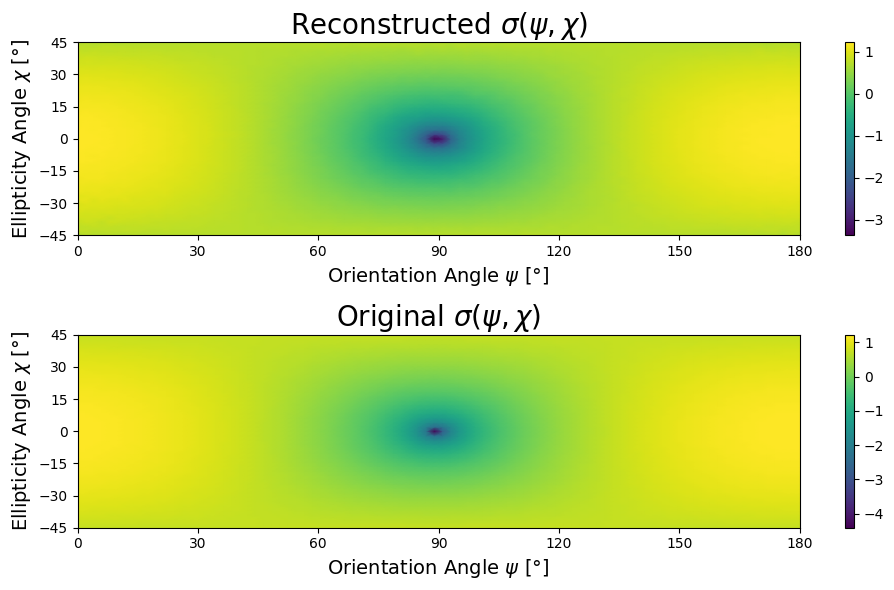

In [15]:
# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(decoded_imgs.shape[0])
rnd_reconstruct_signature = decoded_imgs[rnd_index, :, :, 0]
rnd_signature = scaled_data[rnd_index, :, :, 0]

# Ploteamos
fig, ax = plt.subplots(2, 1)

plot_polarization_signature(rnd_reconstruct_signature, ax=ax[0])
plot_polarization_signature(rnd_signature, ax=ax[1])

ax[0].set_title(r'Reconstructed $\sigma(\psi,\chi)$', fontsize = 20)
ax[1].set_title(r'Original $\sigma(\psi,\chi)$', fontsize = 20)

fig.tight_layout()

Guardamos nuestro modelo junto con su arquitectura

In [16]:
save_model(final_cae, configuration, name="final_cae")

Configuration saved at /home/jotavecorta/proyects/DeepScatteringModels/models/final_cae_configuration_spm.json
Model and weights saved at /home/jotavecorta/proyects/DeepScatteringModels/models/final_cae_model_weights


Guardo el scaler entrenado con los datos finales

In [17]:
models_dir = os.path.normpath(os.getcwd() + "/../models")
scaler_path = os.path.join(models_dir, "final_scaler.pkl")

with open(scaler_path, 'wb') as file_:
    pickle.dump(scaler, file_)